# EGraph Network of the Delagation and Transfer Network

**[Johnnatan Messias](https://johnnatan-messias.github.io/), March 2025**


In [1]:
import os
import json
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import pandas as pd

In [2]:
import sys
code_dir = os.path.realpath(os.path.join(os.getcwd(), "..", "src"))

sys.path.append(code_dir)

In [3]:
dynamic_chart = True
plot_style = 'png' if not dynamic_chart else None

In [4]:
from plot_utils import get_plotly_layout, plot_cdf
from plot_utils import colors
width, height = 850, 450

In [5]:
# Set directory paths
data_dir = os.path.abspath(
    os.path.join(os.getcwd(), "..", "data"))
plots_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "plots"))
graph_dir = os.path.abspath(
    os.path.join(os.getcwd(), "..", "graph"))

# Create directories if they don't exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(graph_dir, exist_ok=True)

In [6]:
protocol_names = ['compound', 'uniswap']

In [7]:
def load_dataframes(file_dir):
    df = pd.read_csv(file_dir)
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    return df

In [8]:
file_fir = os.path.join(
    data_dir, "blocks", "block_timestamp__9600000_20563001.csv.gz")
blocks_df = load_dataframes(file_fir)
blocks_df.head()

,number,timestamp
0,20563001,2024-08-19 13:34:11+00:00
1,20563000,2024-08-19 13:33:59+00:00
2,20562999,2024-08-19 13:33:47+00:00
3,20562998,2024-08-19 13:33:35+00:00
4,20562997,2024-08-19 13:33:23+00:00


In [9]:
dfs = dict(compound=dict(), uniswap=dict())
for protocol_name in protocol_names:
    print(f"Loading {protocol_name} dataframes")
    for filename in ["delegatechanged_df.csv.gz", "delegatevoteschanged_df.csv.gz", "transfer_df.csv.gz"]:
        print("\tLoading", filename)
        file_dir = os.path.join(data_dir, protocol_name, filename)
        df = load_dataframes(file_dir)
        df.sort_values(
            ['blockNumber', 'transactionIndex', 'logIndex'], inplace=True)
        eventname = filename.split("_")[0]
        dfs[protocol_name][eventname] = df
        print("\t\tThere are", len(df), "rows in the dataframe")

Loading compound dataframes
	Loading delegatechanged_df.csv.gz
		There are 15244 rows in the dataframe
	Loading delegatevoteschanged_df.csv.gz
		There are 83798 rows in the dataframe
	Loading transfer_df.csv.gz
		There are 2224966 rows in the dataframe
Loading uniswap dataframes
	Loading delegatechanged_df.csv.gz
		There are 53977 rows in the dataframe
	Loading delegatevoteschanged_df.csv.gz
		There are 163347 rows in the dataframe
	Loading transfer_df.csv.gz
		There are 4765566 rows in the dataframe


### Loading labels


In [10]:
labels_dir = os.path.join(data_dir, "labels")
with open(os.path.join(labels_dir, "labels.json")) as f:
    labels = json.load(f)
print("Labels loaded: {}".format(len(labels)))

Labels loaded: 29738


## Data Parser


In [11]:
delegators = dict()
for protocol_name in protocol_names:
    data = dfs[protocol_name]['delegatechanged'].groupby(
        'delegator').last()
    data.reset_index(inplace=True)
    data['toDelegate_label'] = data['toDelegate'].apply(
        lambda x: labels.get(x, x[:6]+"..."+x[-4:]))
    delegators[protocol_name] = data

In [12]:
delegators['compound']['toDelegate_label'].value_counts().head(15)

toDelegate_label
a16z                     578
Polychain Capital        465
Gauntlet                 148
InstaDApp                 98
Robert Leshner            92
blck                      78
Bain Capital Venture…     60
Dharma_HQ                 60
Wintermute                59
Ryan Adams                57
Kyber Network             48
PoolTogether Core Te…     41
Kain | Synthetix          40
MonetSupply               39
Paradigm                  30
Name: count, dtype: int64

In [13]:
delegators['uniswap']['toDelegate_label'].value_counts().head(15)

toDelegate_label
MultiSig: Univalent    453
a16z                   174
Andre Cronje           149
丰密kuiqian.eth          139
Dharma_HQ              131
Test 1                 128
Michigan Blockchain     83
Gauntlet                81
MonetSupply             80
Wintermute              72
Autonomous Proposal     66
Pranjal                 64
Consensys               62
jessewldn               59
teemulaumhonkasalo      49
Name: count, dtype: int64

In [14]:
delegatee_balances = dict()
for protocol_name in protocol_names:
    delegatee_balances[protocol_name] = dfs[protocol_name]['delegatevoteschanged'][[
        'delegate', 'previousBalance', 'newBalance']].groupby('delegate')['newBalance'].last()
    display(delegatee_balances[protocol_name].sort_values(
        ascending=False).head(10))

delegate
0x9aa835bc7b8ce13b9b0c9764a52fbf71ac62ccf1    361007.863282
0x7e959eab54932f5cfd10239160a7fd6474171318    170000.000000
0x8169522c2c57883e8ef80c498aab7820da539806    101007.831007
0x683a4f9915d6216f73d6df50151725036bd26c02     90066.401695
0x2210dc066aacb03c9676c4f1b36084af14ccd02e     89375.329736
0x8d07d225a769b7af3a923481e1fdf49180e6a265     85003.804077
0xc3aae58ab81663872dd36d73613eb295b167f546     85001.846830
0x54a37d93e57c5da659f508069cf65a381b61e189     80092.915113
0xb933aee47c438f22de0747d57fc239fe37878dd1     80003.154534
0x070341aa5ed571f0fb2c4a5641409b1a46b4961b     70000.242187
Name: newBalance, dtype: float64

delegate
0x8e4ed221fa034245f14205f781e0b13c5bd6a42e    9.006452e+06
0x53689948444cfd03d2ad77266b05e61b8eed3132    9.000025e+06
0xe7925d190aea9279400cd9a005e33ceb9389cc2b    8.000556e+06
0x1d8f369f05343f5a642a78bd65ff0da136016452    8.000011e+06
0xe02457a1459b6c49469bf658d4fe345c636326bf    7.300000e+06
0x88e15721936c6eba757a27e54e7ae84b1ea34c05    7.250000e+06
0x8962285faac45a7cbc75380c484523bb7c32d429    7.034556e+06
0xcb70d1b61919dae81f5ca620f1e5d37b2241e638    7.000000e+06
0x88fb3d509fc49b515bfeb04e23f53ba339563981    5.342995e+06
0x683a4f9915d6216f73d6df50151725036bd26c02    5.251071e+06
Name: newBalance, dtype: float64

In [15]:
delegate_dfs = dict()
for protocol_name in protocol_names:
    df = delegatee_balances[protocol_name].to_frame().reset_index()
    df.columns = ['address', 'balance']
    df.sort_values(by='balance', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['address_label'] = df['address'].apply(
        lambda x: labels.get(x, x[:6]+"..."+x[-4:]))
    delegate_dfs[protocol_name] = df
    print("There are {} unique delegates in {}".format(
        len(df), protocol_name))
    display(df.head())

There are 7794 unique delegates in compound


,address,balance,address_label
0,0x9aa835bc7b8ce13b9b0c9764a52fbf71ac62ccf1,361007.863282,a16z
1,0x7e959eab54932f5cfd10239160a7fd6474171318,170000.000000,0x7e95...1318
2,0x8169522c2c57883e8ef80c498aab7820da539806,101007.831007,Geoffrey Hayes
3,0x683a4f9915d6216f73d6df50151725036bd26c02,90066.401695,Gauntlet
4,0x2210dc066aacb03c9676c4f1b36084af14ccd02e,89375.329736,bryancolligan


There are 43569 unique delegates in uniswap


,address,balance,address_label
0,0x8e4ed221fa034245f14205f781e0b13c5bd6a42e,9.006452e+06,0x8e4e...a42e
1,0x53689948444cfd03d2ad77266b05e61b8eed3132,9.000025e+06,0x5368...3132
2,0xe7925d190aea9279400cd9a005e33ceb9389cc2b,8.000556e+06,jessewldn
3,0x1d8f369f05343f5a642a78bd65ff0da136016452,8.000011e+06,0x1d8f...6452
4,0xe02457a1459b6c49469bf658d4fe345c636326bf,7.300000e+06,0xe024...26bf


In [16]:
for protocol_name in protocol_names:
    print("Protocol: ", protocol_name)
    data = delegate_dfs[protocol_name].sort_values(
        by="balance", ascending=False)
    print("\tTotal deletated tokens: ", data['balance'].sum())
    print("\tTotal deletated tokens belonging to the top 15 holders: ",
          data['balance'].head(15).sum())
    print("\tThe percentage of the top 15 deletated holders: ",
          data['balance'].head(15).sum()/data['balance'].sum())
    print("\tThe percentage of the top 10 deletated holders: ",
          data['balance'].head(10).sum()/data['balance'].sum())

Protocol:  compound
	Total deletated tokens:  2397812.8294997048
	Total deletated tokens belonging to the top 15 holders:  1476575.9860580321
	The percentage of the top 15 deletated holders:  0.6158011867699092
	The percentage of the top 10 deletated holders:  0.5052768813125852
Protocol:  uniswap
	Total deletated tokens:  204854205.56498438
	Total deletated tokens belonging to the top 15 holders:  98267623.58166163
	The percentage of the top 15 deletated holders:  0.4796954170925669
	The percentage of the top 10 deletated holders:  0.35725733247155844


In [17]:
# Loading account balances
balances_dict = dict()
for protocol_name in tqdm(protocol_names, desc="Computing balances"):
    balances_dict[protocol_name] = dict()
    for _, row in tqdm(dfs[protocol_name]['transfer'].iterrows(),
                       desc='Loading balances', total=dfs[protocol_name]['transfer'].shape[0]):
        if row['from'] not in balances_dict[protocol_name]:
            balances_dict[protocol_name][row['from']] = 0
        if row['to'] not in balances_dict[protocol_name]:
            balances_dict[protocol_name][row['to']] = 0
        balance = row['amount']
        balances_dict[protocol_name][row['from']] -= balance
        balances_dict[protocol_name][row['to']] += balance
    print("{}: There are in total {} addresses".format(
        protocol_name.capitalize(), len(balances_dict[protocol_name])))
    df = pd.DataFrame.from_dict(
        balances_dict[protocol_name], orient='index').reset_index()
    df.columns = ['address', 'balance']
    df = df.sort_values(
        by='balance', ascending=False).reset_index(drop=True)
    df = df.query('balance > 0')
    df['address_label'] = df['address'].apply(
        lambda x: labels.get(x, x[:6]+"..."+x[-4:]))
    display(df.head())

    balances_dict[protocol_name] = df

Computing balances:   0%|          | 0/2 [00:00<?, ?it/s]

Loading balances:   0%|          | 0/2224966 [00:00<?, ?it/s]

Compound: There are in total 645369 addresses


,address,balance,address_label
0,0x3d9819210a31b4961b30ef54be2aed79b9c9cd3b,1.578590e+06,Compound: Comptroller
1,0xc3d688b66703497daa19211eedff47f25384cdc3,8.999951e+05,Compound: USDCv3 Token
2,0xf977814e90da44bfa03b6295a0616a897441acec,5.203256e+05,Binance
3,0x73af3bcf944a6559933396c1577b257e2054d935,4.767118e+05,0x73af...d935
4,0x3f4aa3aa9fa1afe43897627a9a964235c0bf9375,2.845766e+05,0x3f4a...9375


Loading balances:   0%|          | 0/4765566 [00:00<?, ?it/s]

Uniswap: There are in total 1345922 addresses


,address,balance,address_label
0,0x1a9c8182c09f50c8318d769245bea52c32be35bc,3.831143e+08,Uniswap V2: UNI Timelock
1,0x47173b170c64d16393a52e6c480b3ad8c302ba1e,2.304748e+07,0x4717...ba1e
2,0x3d30b1ab88d487b0f3061f40de76845bec3f1e94,1.677607e+07,Uniswap Protocol: Treasury Vester
3,0xf977814e90da44bfa03b6295a0616a897441acec,1.638710e+07,Binance
4,0x7d2d43e63666f45b40316b44212325625dbaeb40,1.325469e+07,0x7d2d...eb40


In [19]:
dfs[protocol_name]['delegatechanged']

,blockNumber,transactionHash,blockHash,address,transactionIndex,logIndex,event,delegator,fromDelegate,toDelegate
0,10863690,1a31db380ee03a6b066a682320e96411537f8f25b6bcea...,a3077dbc57bd9106318a460dde5bf61b2831f3959b21e8...,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,144,279,DelegateChanged,0x7ce77efa0d84104b3806af29b62814e6a27e427d,0x0000000000000000000000000000000000000000,0x557847aa724ea004041522ee550e1ae14ced6d7e
1,10866944,d1ffb1b52ae8e5e26941e615674e03c8d925e3267f8eb4...,02e800fee5fec450de182ba63afce47025e26a1963e91b...,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,164,254,DelegateChanged,0xa372c89b4a6b4e6d06c1483698d94eed6ae0e52b,0x0000000000000000000000000000000000000000,0xdc3e25c323035b226d9aab3f8ea4e9ea4f95fc3f
2,10876484,2dd49982dbf54d4d995864c10b8e8ac7caad53311c8123...,a7aefee6e1b29e0c02cc9e448b6e329e94bcf670649b77...,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,135,355,DelegateChanged,0x272370bcf690fc496470429b0bdc09b841dd1cde,0x0000000000000000000000000000000000000000,0x272370bcf690fc496470429b0bdc09b841dd1cde
3,10876488,9c17b77624dd2a7749a1b31e8bf72ffd32d7d4186a582a...,2da3a1e906bc7755f9aa835de5a22c4123ece0b20a6420...,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,86,209,DelegateChanged,0x393dee493278be5a67be76ae3f73ff66884d2b21,0x0000000000000000000000000000000000000000,0x393dee493278be5a67be76ae3f73ff66884d2b21
4,10876488,bc70c742c17835747374200eb0a7c950f93368a010fbdb...,2da3a1e906bc7755f9aa835de5a22c4123ece0b20a6420...,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,90,222,DelegateChanged,0x2e10104bd7b3e7c659f6f802166be3fcdcd0c097,0x0000000000000000000000000000000000000000,0x2e10104bd7b3e7c659f6f802166be3fcdcd0c097
...,...,...,...,...,...,...,...,...,...,...
53972,20561881,80bd2d82a3596252dfbcde09fe8b6cbfb3eb3aa5ae5a9f...,6964e5fbad6c235b94e80f885697b83ecb0eaed6274a15...,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,78,206,DelegateChanged,0xd243ef40044ea52b09f1b3886506de3cecca4a44,0x0000000000000000000000000000000000000000,0xd243ef40044ea52b09f1b3886506de3cecca4a44
53973,20561995,af1efe7eff051fe3acad09614d17f0738a9f8ef22522af...,8d5e9b2241fde2b303407b53ad4a5ddc77caebfd0228b0...,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,32,53,DelegateChanged,0x9275b649c54503180617cd9fb70d47d1dc1bf8c9,0xf3fe8c6c75be4afb2f8200fc77339abe4d7cff33,0x9275b649c54503180617cd9fb70d47d1dc1bf8c9
53974,20562013,0b8c9f33fa2e845c68af1ed1904ec10c6cf4d1ab54b08d...,e08dd5fd4b1c03022059eb210e963ff03ad8a75a78820d...,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,59,109,DelegateChanged,0x8479a34adfd6ac1b454306c9345cc74241b3f225,0xf3fe8c6c75be4afb2f8200fc77339abe4d7cff33,0x8479a34adfd6ac1b454306c9345cc74241b3f225
53975,20562052,f82dcda44848fe220c891509ecaa9b0763fa689342f490...,66fec582b52dfc1060a089991de893bb202ec56fc20bf7...,0x1f9840a85d5af5bf1d1762f925bdaddc4201f984,40,33,DelegateChanged,0x21912c7cffbd8952384de295952f02813279819a,0x0000000000000000000000000000000000000000,0x21912c7cffbd8952384de295952f02813279819a


In [20]:
delegated_addresses_df = dict()
for protocol_name in protocol_names:
    df = dfs[protocol_name]['delegatechanged'].groupby(
        'delegator'
    ).last().reset_index()[
        ['transactionHash', 'blockNumber', 'delegator', 'fromDelegate', 'toDelegate']
    ].merge(balances_dict[protocol_name], left_on='delegator', right_on='address', how='left').drop(columns=['address'])
    # df['delegator_label'] = df['delegator'].replace(
    #     labels)
    df['delegator_label'] = df['delegator'].apply(
        lambda x: labels.get(x, x[:6]+"..."+x[-4:]))
    # df['toDelegate_label'] = df['toDelegate'].replace(
    #     labels)
    df['toDelegate_label'] = df['toDelegate'].apply(
        lambda x: labels.get(x, x[:6]+"..."+x[-4:]))
    df['balance'] = df['balance'].fillna(0)

    total_balance = df.groupby('toDelegate').agg(
        {'balance': 'sum'}).reset_index().sort_values(by='balance', ascending=False)
    total_balance.columns = ['toDelegate', 'total_delegated_amount']
    df = df.merge(
        total_balance, on='toDelegate', how='left')
    delegated_addresses_df[protocol_name] = df

# Graph Network


In [21]:
import networkx as nx

In [22]:
dead_addresses = pd.read_csv(os.path.join(data_dir, "dead_addresses.csv"))
dead_addresses = set(dead_addresses['address'])
print("There are {} dead addresses".format(len(dead_addresses)))

There are 31 dead addresses


In [23]:
def show_graph_info(graph):
    print("There are {} nodes and {} edges".format(
        graph.number_of_nodes(), graph.number_of_edges()))
    print("There are {} connected components".format(
        nx.number_connected_components(graph.to_undirected())))
    largest_component = sorted(nx.connected_components(
        graph.to_undirected()), key=len, reverse=True)[0]
    print("The largest component has {} nodes".format(len(largest_component)))

In [24]:
delegated_addresses_df['compound']

,transactionHash,blockNumber,delegator,fromDelegate,toDelegate,balance,address_label,delegator_label,toDelegate_label,total_delegated_amount
0,1aefebdb36a5be6affcabac4334dddb404e0955e293865...,14366021,0x0000000c50489ced5f512c74fb11ba9af3a03e13,0x0000000000000000000000000000000000000000,0x0000000c50489ced5f512c74fb11ba9af3a03e13,0.000000e+00,NaN,ClairvoyantLabs,ClairvoyantLabs,0.000000e+00
1,3ef04480f9d20342d5c367b88245ee625f0909a7d05f2c...,14777766,0x0003cb0009e52e6ca64b4744a1601e9f1d6ef130,0x0000000000000000000000000000000000000000,0x0003cb0009e52e6ca64b4744a1601e9f1d6ef130,4.000000e-03,0x0003...f130,0x0003...f130,0x0003...f130,4.000000e-03
2,e87722671e2d37762e9b5f6ef20f28a6a50995fbf9119c...,14822917,0x000631989ad80246d4e847a9687b4a2bf7d4ec4c,0x0000000000000000000000000000000000000000,0x000631989ad80246d4e847a9687b4a2bf7d4ec4c,5.000000e-03,0x0006...ec4c,0x0006...ec4c,0x0006...ec4c,5.000000e-03
3,c1bcd9c1322f2886c1fd0fa960777d09f2ca191168236d...,11441158,0x0006e4548aed4502ec8c844567840ce6ef1013f5,0x5576a4db81a44cb7158fc8d5ae752cb44f57be76,0x0006e4548aed4502ec8c844567840ce6ef1013f5,7.216450e-15,0x0006...13f5,0x0006...13f5,0x0006...13f5,7.216450e-15
4,23d5306c8d8e1d37c21872f5a2cfa1761655430060a34c...,16172574,0x0008bb335a71a97ae89cf99388d7be70d7ef4660,0xea6c3db2e7fca00ea9d7211a03e83f568fc13bf7,0x0008bb335a71a97ae89cf99388d7be70d7ef4660,6.617227e-02,0x0008...4660,0x0008...4660,0x0008...4660,6.617227e-02
...,...,...,...,...,...,...,...,...,...,...
13079,62a6ec9df0cc3302a28fa09d75c69c9741f7fbb5a296e3...,10312049,0xffdc0c7dff4bdabc76e69f1ffd0c11d54b21369b,0x0000000000000000000000000000000000000000,0xffdc0c7dff4bdabc76e69f1ffd0c11d54b21369b,1.010430e-02,0xffdc...369b,0xffdc...369b,0xffdc...369b,1.010430e-02
13080,0ec4615f018032fa6fdcb5ac0d9fba758f6bd9a48019fa...,19757245,0xffe8ec13e22b027312631904ea7f9d4b38cf7730,0x0000000000000000000000000000000000000000,0xb933aee47c438f22de0747d57fc239fe37878dd1,0.000000e+00,NaN,0xffe8...7730,Wintermute,8.000315e+04
13081,13846fd3f76dde5f5759e6ab0b5b1de24b73abe2afb5fb...,14777129,0xffea0b4048c4b14a9e6adb41948b21b9870b18a4,0x0000000000000000000000000000000000000000,0xffea0b4048c4b14a9e6adb41948b21b9870b18a4,1.520000e-01,0xffea...18a4,0xffea...18a4,0xffea...18a4,1.520000e-01
13082,140bcfb40d584df6ec1f6c31de187fe0b6faf76aa5a68b...,13525129,0xfff50b1b9154b0631591dab746c5fc8f41dc44bd,0x0000000000000000000000000000000000000000,0xfff50b1b9154b0631591dab746c5fc8f41dc44bd,0.000000e+00,NaN,0xfff5...44bd,0xfff5...44bd,0.000000e+00


In [25]:
import numpy as np

In [26]:
Gs = dict()
for protocol_name, data in tqdm(delegated_addresses_df.items(), desc='Generating graph network'):
    print(protocol_name)
    G = nx.DiGraph(protocol=protocol_name)
    for _, row in tqdm(data.iterrows(), total=data.shape[0]):
        G.add_edge(row['delegator'], row['toDelegate'], amount=np.float64(row['total_delegated_amount']),
                   from_delegator_label=row['delegator_label'], to_delegate_label=row['toDelegate_label'], block_number=str(row['blockNumber']))
    print("There are {} nodes and {} edges".format(G.number_of_nodes(),
                                                   G.number_of_edges()))
    Gs[protocol_name] = G

Generating graph network:   0%|          | 0/2 [00:00<?, ?it/s]

compound


  0%|          | 0/13084 [00:00<?, ?it/s]

There are 13253 nodes and 13084 edges
uniswap


  0%|          | 0/47675 [00:00<?, ?it/s]

There are 47942 nodes and 47675 edges


In [27]:
Gs_prime = dict()
for protocol_name, graph in Gs.items():
    # Select nodes with degree > 1
    high_degree_nodes = [node for node,
                         degree in graph.degree() if degree >= 1]
    count = len(high_degree_nodes)
    total = graph.number_of_nodes()
    percentage = (count / total) * 100 if total > 0 else 0

    # Output summary
    print(f"{protocol_name.title()}: {count:,} out of {total:,} nodes ({percentage:,.2f}%) have a degree greater than 1.")

    subgraph = graph.subgraph(high_degree_nodes)
    Gs_prime[protocol_name] = subgraph
    print(
        f"\tThe subgraph has {subgraph.number_of_nodes():,} nodes and {subgraph.number_of_edges():,} edges.")

Compound: 13,253 out of 13,253 nodes (100.00%) have a degree greater than 1.
	The subgraph has 13,253 nodes and 13,084 edges.
Uniswap: 47,942 out of 47,942 nodes (100.00%) have a degree greater than 1.
	The subgraph has 47,942 nodes and 47,675 edges.


In [28]:
def subgraph_with_high_degree_nodes(G, D):
    # Step 1: Identify nodes with degree >= D
    high_degree_nodes = {node for node, deg in G.degree() if deg >= D}

    # Step 2: Collect edges where at least one endpoint is a high-degree node
    selected_edges = [
        (u, v) for u, v in G.edges()
        if u in high_degree_nodes or v in high_degree_nodes
    ]

    # Step 3: Create the subgraph containing those edges and their associated nodes
    subG = G.edge_subgraph(selected_edges).copy()

    return subG

In [ ]:
np.clip([0, 1, 2, 3, 4], 1, 2)

array([1, 1, 2, 2, 2])

In [ ]:
def radial_layout_with_center(G, center_node):
    """
    Places center_node at (0, 0) and all other nodes evenly spaced in a circle around it.
    """
    pos = {center_node: (0, 0)}
    # assuming edges point from holder -> delegate
    neighbors = list(G.predecessors(center_node))

    angle_step = 2 * np.pi / max(len(neighbors), 1)
    radius = 1.0

    for i, node in enumerate(neighbors):
        angle = i * angle_step
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        pos[node] = (x, y)

    return pos

In [134]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np


def custom_shell_layout_with_center(G, center_node):
    """
    Custom shell layout where the center_node is placed at the center shell.
    All other nodes are in the outer shell.
    """
    outer_nodes = list(G.nodes())
    outer_nodes.remove(center_node)
    return nx.shell_layout(G, nlist=[[center_node], outer_nodes])


def plot_delegation_graph(G, title="Delegation Network"):
    # Group connected components (ENS-style visualization)
    components = list(nx.weakly_connected_components(G))
    n = len(components)
    cols = int(np.ceil(np.sqrt(n)))
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 3.5))
    axes = axes.flatten() if n > 1 else [axes]

    for ax, comp in zip(axes, components):
        subG = G.subgraph(comp)

        if len(subG) == 1:
            center_node = list(subG.nodes())[0]
            pos = {center_node: (0, 0)}
        else:
            # Select the node with the highest degree to be in the center
            degrees = subG.degree()
            center_node = max(degrees, key=lambda x: x[1])[0]
            pos = custom_shell_layout_with_center(subG, center_node)

        node_sizes = []
        node_colors = []
        for node in subG.nodes:
            in_deg = subG.in_degree(node, weight='amount')
            out_deg = subG.out_degree(node, weight='amount')
            # node_sizes.append(np.clip(in_deg, 10, 500))
            node_sizes.append(np.clip(in_deg, 10, 10000))

            if out_deg > 0 and in_deg == 0:
                node_colors.append('blue')  # holder
            elif in_deg > 0 and out_deg == 0:
                node_colors.append('red')   # delegate
            else:
                # treat both as delegate for visual simplicity
                node_colors.append('red')

        nx.draw_networkx_nodes(
            subG, pos, ax=ax, node_size=node_sizes, node_color=node_colors)
        nx.draw_networkx_edges(
            subG, pos, ax=ax, edge_color='lightpink', width=0.5, arrows=False)

        ax.set_title("")
        ax.set_axis_off()

    for ax in axes[n:]:
        ax.set_axis_off()

    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

In [203]:
labels['0xbe1f4dc51e89cf3f72cc4039bb0104eb96f85733']

'1inch.exchange'

In [133]:
D = 5  # or any threshold you want
for protocol_name, graph in Gs_prime.items():
    filtered_subgraph = subgraph_with_high_degree_nodes(Gs[protocol_name], D)
    nx.write_gexf(filtered_subgraph, os.path.join(
        graph_dir, f"graph_delegation_{protocol_name}.gexf"))

The subgraph has 3,163 nodes and 3,119 edges.


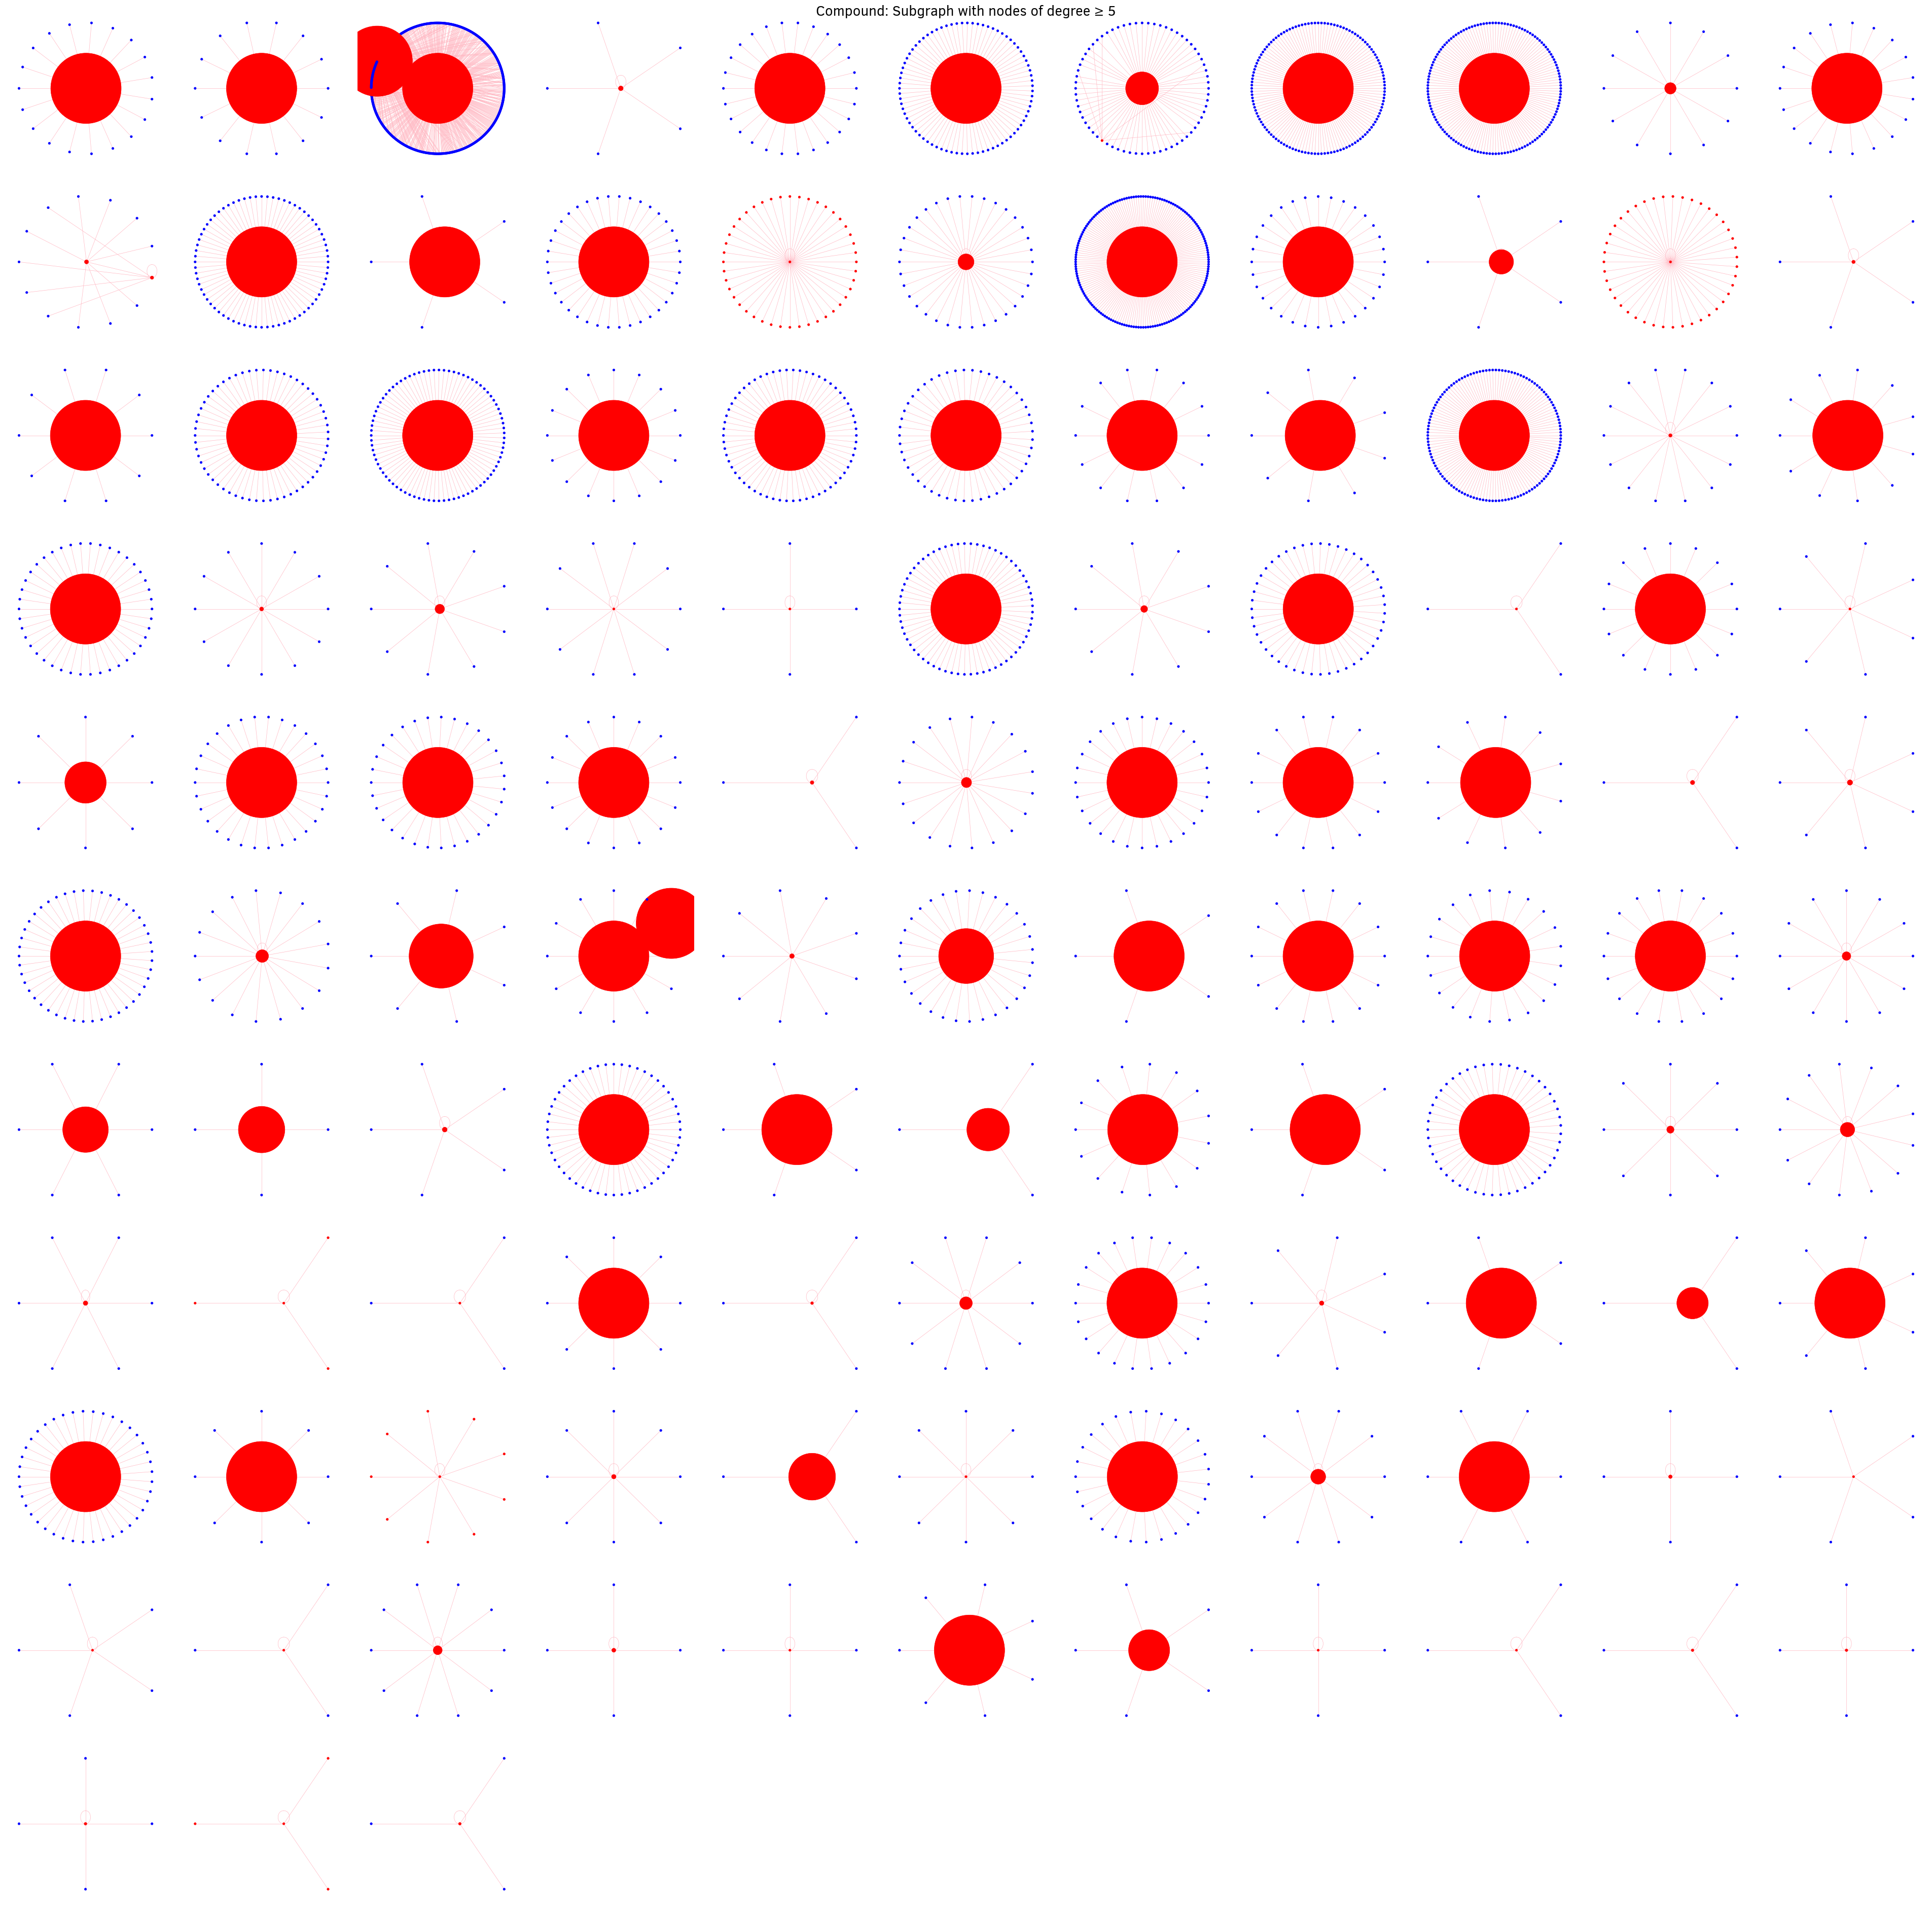

In [135]:
D = 5  # or any threshold you want
filtered_subgraph = subgraph_with_high_degree_nodes(Gs["uniswap"], D)
print(
    f"The subgraph has {filtered_subgraph.number_of_nodes():,} nodes and {filtered_subgraph.number_of_edges():,} edges.")
plot_delegation_graph(
    filtered_subgraph, f"Compound: Subgraph with nodes of degree ≥ {D}")

In [32]:
# import matplotlib.pyplot as plt
# import networkx as nx
# protocol_name = "compound"

# print("Computing positions")
# pos = nx.spring_layout(Gs_prime[protocol_name])

# # Plotting
# print("Plotting")
# plt.figure(figsize=(10, 10))
# nx.draw(G, pos, node_color=['red', 'blue'],
#         with_labels=False, edge_color='lightpink', arrows=False)
# plt.title(f"{protocol_name.title()} Delegation Network")
# plt.axis('off')
# plt.show()